In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=gpu'
sys.path.append(os.getcwd()+"/..")
import theano.tensor as T
import theano
import lasagne

from tasks import check
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from tqdm import tqdm

%matplotlib inline
from IPython.display import Image

import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
from helpers import salt_and_pepper
import lasagne
import pickle
from lasagne import layers

def load_gan_model(filename):
    import dcgan
    
    data = pickle.load(open(filename))
    gen = data['generator']
    discr = data['discriminator']
    return gen, discr

def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

def floatX(x):
    return x.astype(np.float32)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def sigmoid(x):
    return 1./(1. + np.exp(-x))

from tools.brushstroke.common import to_grid_of_images, disp_grid
from tools.brushstroke.common import load_model, get_bias, get_scale
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG

Using gpu device 0: Tesla K20Xm (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


## load model

In [2]:
from lightjob.cli import load_db
db = load_db()
s = db.get_job_by_summary('73da00fd56f4bba3a9cf4502d045ef70')['content']['model_summary']
filename = "../jobs/results/{}/model.pkl".format(s)

filename ='../jobs/results/1b5f929796b52352a009ab37f602bfbf/model.pkl'

In [3]:
capsule, data, layers = load_model(filename)
c, w, h = layers['input'].shape[1:]

(None, 1, 28, 28)
Loading data...


INFO:tasks:Loading data...


(None, 1, 28, 28)
(None, 1, 28, 28)
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


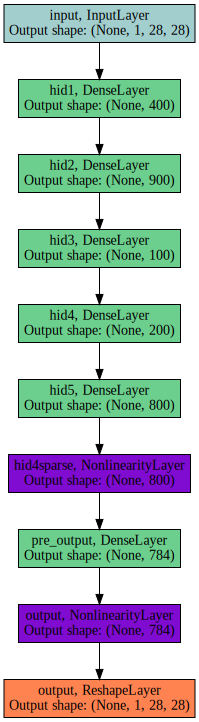

In [7]:
draw_to_file(L.get_all_layers(layers['output']), 'out.svg')
SVG('out.svg')

In [8]:
for l in layers:
    print(l)

input
hid1
hid2
hid3
hid4
hid5
hid4sparse
pre_output
output


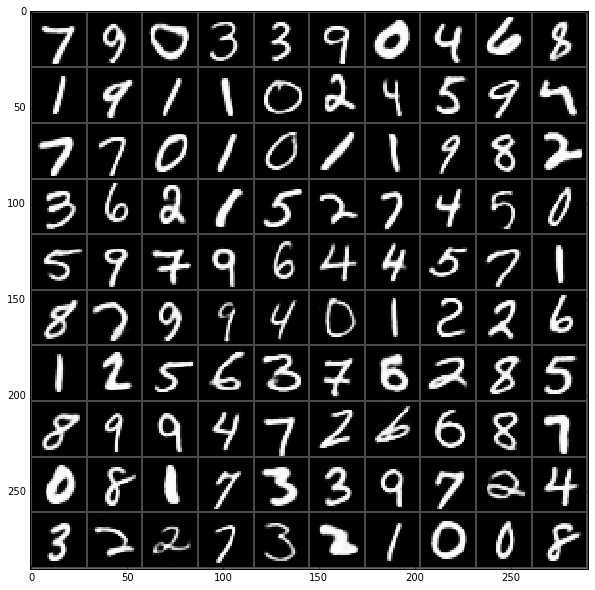

In [4]:
data.load()
X = data.X[0:100]
X = capsule.preprocess(X)
Xrec = capsule.reconstruct(X)
fig = plt.figure(figsize=(10,10))
plt.imshow(disp_grid(Xrec, border=1, bordercolor=(0.3,0.3,0.3)), interpolation='none')

## ProgramNeural network

In [ ]:
X_t = T.tensor4()
get_coords = theano.function([X_t], L.get_output(layers['coord_0_normalized'], X_t))
get_repr = theano.function([X_t], L.get_output(layers['repr_0_normalized'], X_t))

C = T.tensor3()
R = T.tensor3()
render = theano.function(
    [C, R],
    L.get_output(layers['output'], 
                 {layers['coord_0_normalized']: C, layers['repr_0_normalized']: R}, 
                 deterministic=True)
)

In [ ]:
feat_layers = [l for l in layers.keys() if 'normalized' in l]
get_feats = theano.function([X_t], [L.get_output(layers[l], X_t) for l in feat_layers])

In [ ]:
#get_coords_1 = theano.function([X_t], L.get_output(layers['coord_1_0_normalized'], X_t))
#get_rel_coords_1 = theano.function([X_t], L.get_output(layers['coord_5_0'], X_t))

In [ ]:
X = data.X[0:9]
X = capsule.preprocess(X)
coords = get_coords(X)
reprs = get_repr(X)

In [ ]:
reprs_ = reprs.copy()
coords_ = coords.copy()
coords_[:]=0.5
reprs_[:]=0
#coords_[:]=-10
#coords_[:,0]=0.5
#reprs_[:,0,0]=1

In [ ]:
Xrec = render(coords_, reprs_)
Xrec = Xrec
img = disp_grid(Xrec, border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png', width=400, height=400)

## Only come here To check vertebrate  convnets

In [ ]:
for l in layers.keys():
    print(l)

In [7]:
print(layers)
code_layers = ['hid5']
X_t = T.tensor4()
encode = theano.function(
    [X_t], 
    [L.get_output(layers[cc], X_t) for cc in code_layers]
)
code_t = [T.tensor4() for _ in code_layers]
decode = theano.function(
    code_t,
    L.get_output(layers['output'], {layers[name]: t for name, t in zip(code_layers, code_t)})
)

OrderedDict([('input', <lasagne.layers.input.InputLayer object at 0x7f82c5f03f90>), ('hid1', <lasagne.layers.dense.DenseLayer object at 0x7f82d82a7c90>), ('hid2', <lasagne.layers.dense.DenseLayer object at 0x7f82b9f20790>), ('hid3', <lasagne.layers.dense.DenseLayer object at 0x7f82b9f20a10>), ('hid4', <lasagne.layers.dense.DenseLayer object at 0x7f82b9f20ed0>), ('hid5', <lasagne.layers.dense.DenseLayer object at 0x7f82b9f20b90>), ('hid4sparse', <lasagne.layers.special.NonlinearityLayer object at 0x7f82d82a75d0>), ('pre_output', <lasagne.layers.dense.DenseLayer object at 0x7f82b9f20690>), ('output', <lasagne.layers.shape.ReshapeLayer object at 0x7f82dfbd71d0>)])


In [20]:
X = data.X[0:100]
X=capsule.preprocess(X)

In [21]:
C = encode(X)
Xrec = decode(*C)

TypeError: ('Bad input argument to theano function with name "<ipython-input-19-2928d34c8d63>:11" at index 0 (0-based)', 'Wrong number of dimensions: expected 4, got 2 with shape (100, 800).')

In [ ]:
m = C[3][0][:, None, :, :]
fig = plt.figure(figsize=(10,10))
plt.imshow(disp_grid(m, border=1, bordercolor=(0.3, 0, 0)))

In [ ]:
C = list(encode(X))
cc = []#include these
for i in set(range(len(C))) - set(cc):
    C[i][:] = 0
C_zeros = [np.zeros_like(c) for c in C]
M = [0]#change these
"""
for _ in range(4):
    for i in M:
        F = C[i].shape[1]
        W = C[i].shape[2]
        H = C[i].shape[3]
        N = min(C[i].shape[0], F)
        C[i][np.arange(N), 
             np.arange(N), 
             np.random.randint(0, W, size=N), 
             np.random.randint(0, H, size=N)
             #0,
             #0,
        ] = 30
"""

for i in M:
    for n in range(N):
        F = C[i].shape[1]
        W = C[i].shape[2]
        H = C[i].shape[3]
        C[i][n, np.arange(F), np.random.randint(0, H, size=F), np.random.randint(0, W, size=F)] = 10

fig = plt.figure(figsize=(20, 20))
Xrec = decode(*C)
X_rec_zero = decode(*C_zeros)

res = Xrec# - X_rec_zero
recons = dispims_color(res.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1, bordercolor=(0.5,0.5,0.5))
plt.imshow(recons)

## viz features

input
hid1
(400, 28, 28, 3)


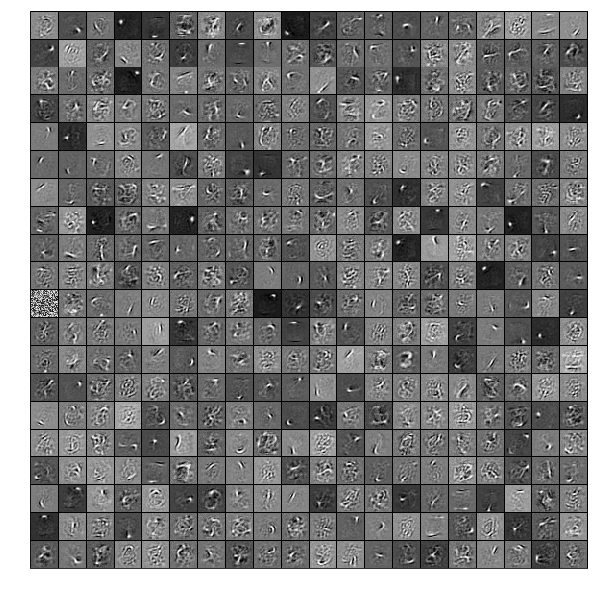

hid2
hid3
hid4
hid5
hid4sparse
pre_output
(800, 28, 28, 3)


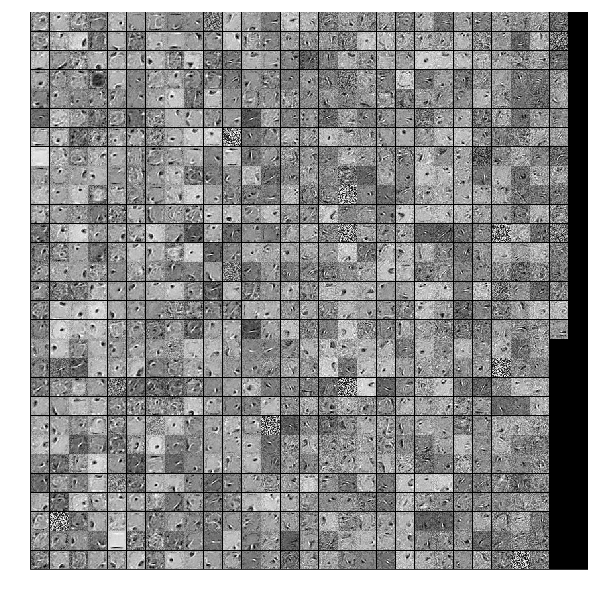

output


In [10]:
nbpixels = 28*28
c=1
for name, layer in layers.items():
    print(name)
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2 and (W.shape[0] == nbpixels or W.shape[1] == nbpixels):
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            W = W.reshape((W.shape[0], c, w, h))
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[1] in (1, 3):
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[0] in (1, 3):
            W = W.transpose((1, 2, 3, 0))
            W = W * np.ones((1, 1, 1, 3))
        else:
            #print(W.shape)
            continue
        fig = plt.figure(figsize=(10, 10))
        plt.axis('off')
        print(W.shape)
        img = dispims_color(W, border=1)
        plt.imshow(img, interpolation='none')
        plt.show()

## iterative refinement

In [122]:
seed = np.random.randint(1, 1000)
np.random.seed(seed)
nb_iter = 100
N= 12800
c=1
imgs = np.empty((N, nb_iter + 1, c, w, h))
imgs = imgs.astype(np.float32)
imgs[:, 0] = np.random.uniform(size=(N, c, w, h))
thresh = 'moving'
do_binarize = True
do_sample = False
whitepx_ratio = 0.13
bs = 128
for i in (range(1, nb_iter + 1)):
    sprev = imgs[:, i - 1]
    s = sprev.copy()
    for j in range(0, s.shape[0], bs):
        s[j:j+bs] = capsule.reconstruct(s[j:j+bs])
    #s = capsule.reconstruct(s)
    if do_sample:
        s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')
    if do_binarize:
        if thresh == 'moving':
            vals = s.flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        #print(thresh_)
        s = s > thresh_
    imgs[:, i] = s
    score = float(np.abs(s - sprev).mean())
    #print(score)
    if score == 0:
        print('end')
        imgs = imgs[:, 0:i+1]
        break
samples = imgs.transpose((1, 0, 2, 3, 4))

In [71]:
# sample samples and iterations
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
samples_ = 1 - samples_
img = dispims_color(samples_, shape=(sw, sh), border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png')

In [72]:
import os
from scripts.imgtovideo import imgs_to_video
from tools.brushstroke.common import embed_video
imgs = []
for s in samples:
    img = dispims_color((1-s).transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=2, bordercolor=(0.3, 0, 0))
    imgs.append(img)
if os.path.exists('out.mp4'):
    os.remove('out.mp4')
imgs_to_video(imgs, out='out.mp4', verbose=10, framerate=10, rate=10)
embed_video('out.mp4')

KeyboardInterrupt: 

## sne

In [127]:
a=1
print(d.shape)

(13400, 1, 28, 28)


In [ ]:
mf = TSNE(n_components=2, perplexity=30)
#mf = PCA(n_components=2)
X = data.train.X[0:14400 - len(samples[-1])]
X = X.reshape((X.shape[0], c, h, w))
d = np.concatenate((X, samples[-1]), axis=0)
labels = np.array([1] * len(X) + [0] * len(samples[-1]))
hid, = encode(d)
hid = hid.reshape((hid.shape[0], -1))
h2d = mf.fit_transform(hid)

14400


/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


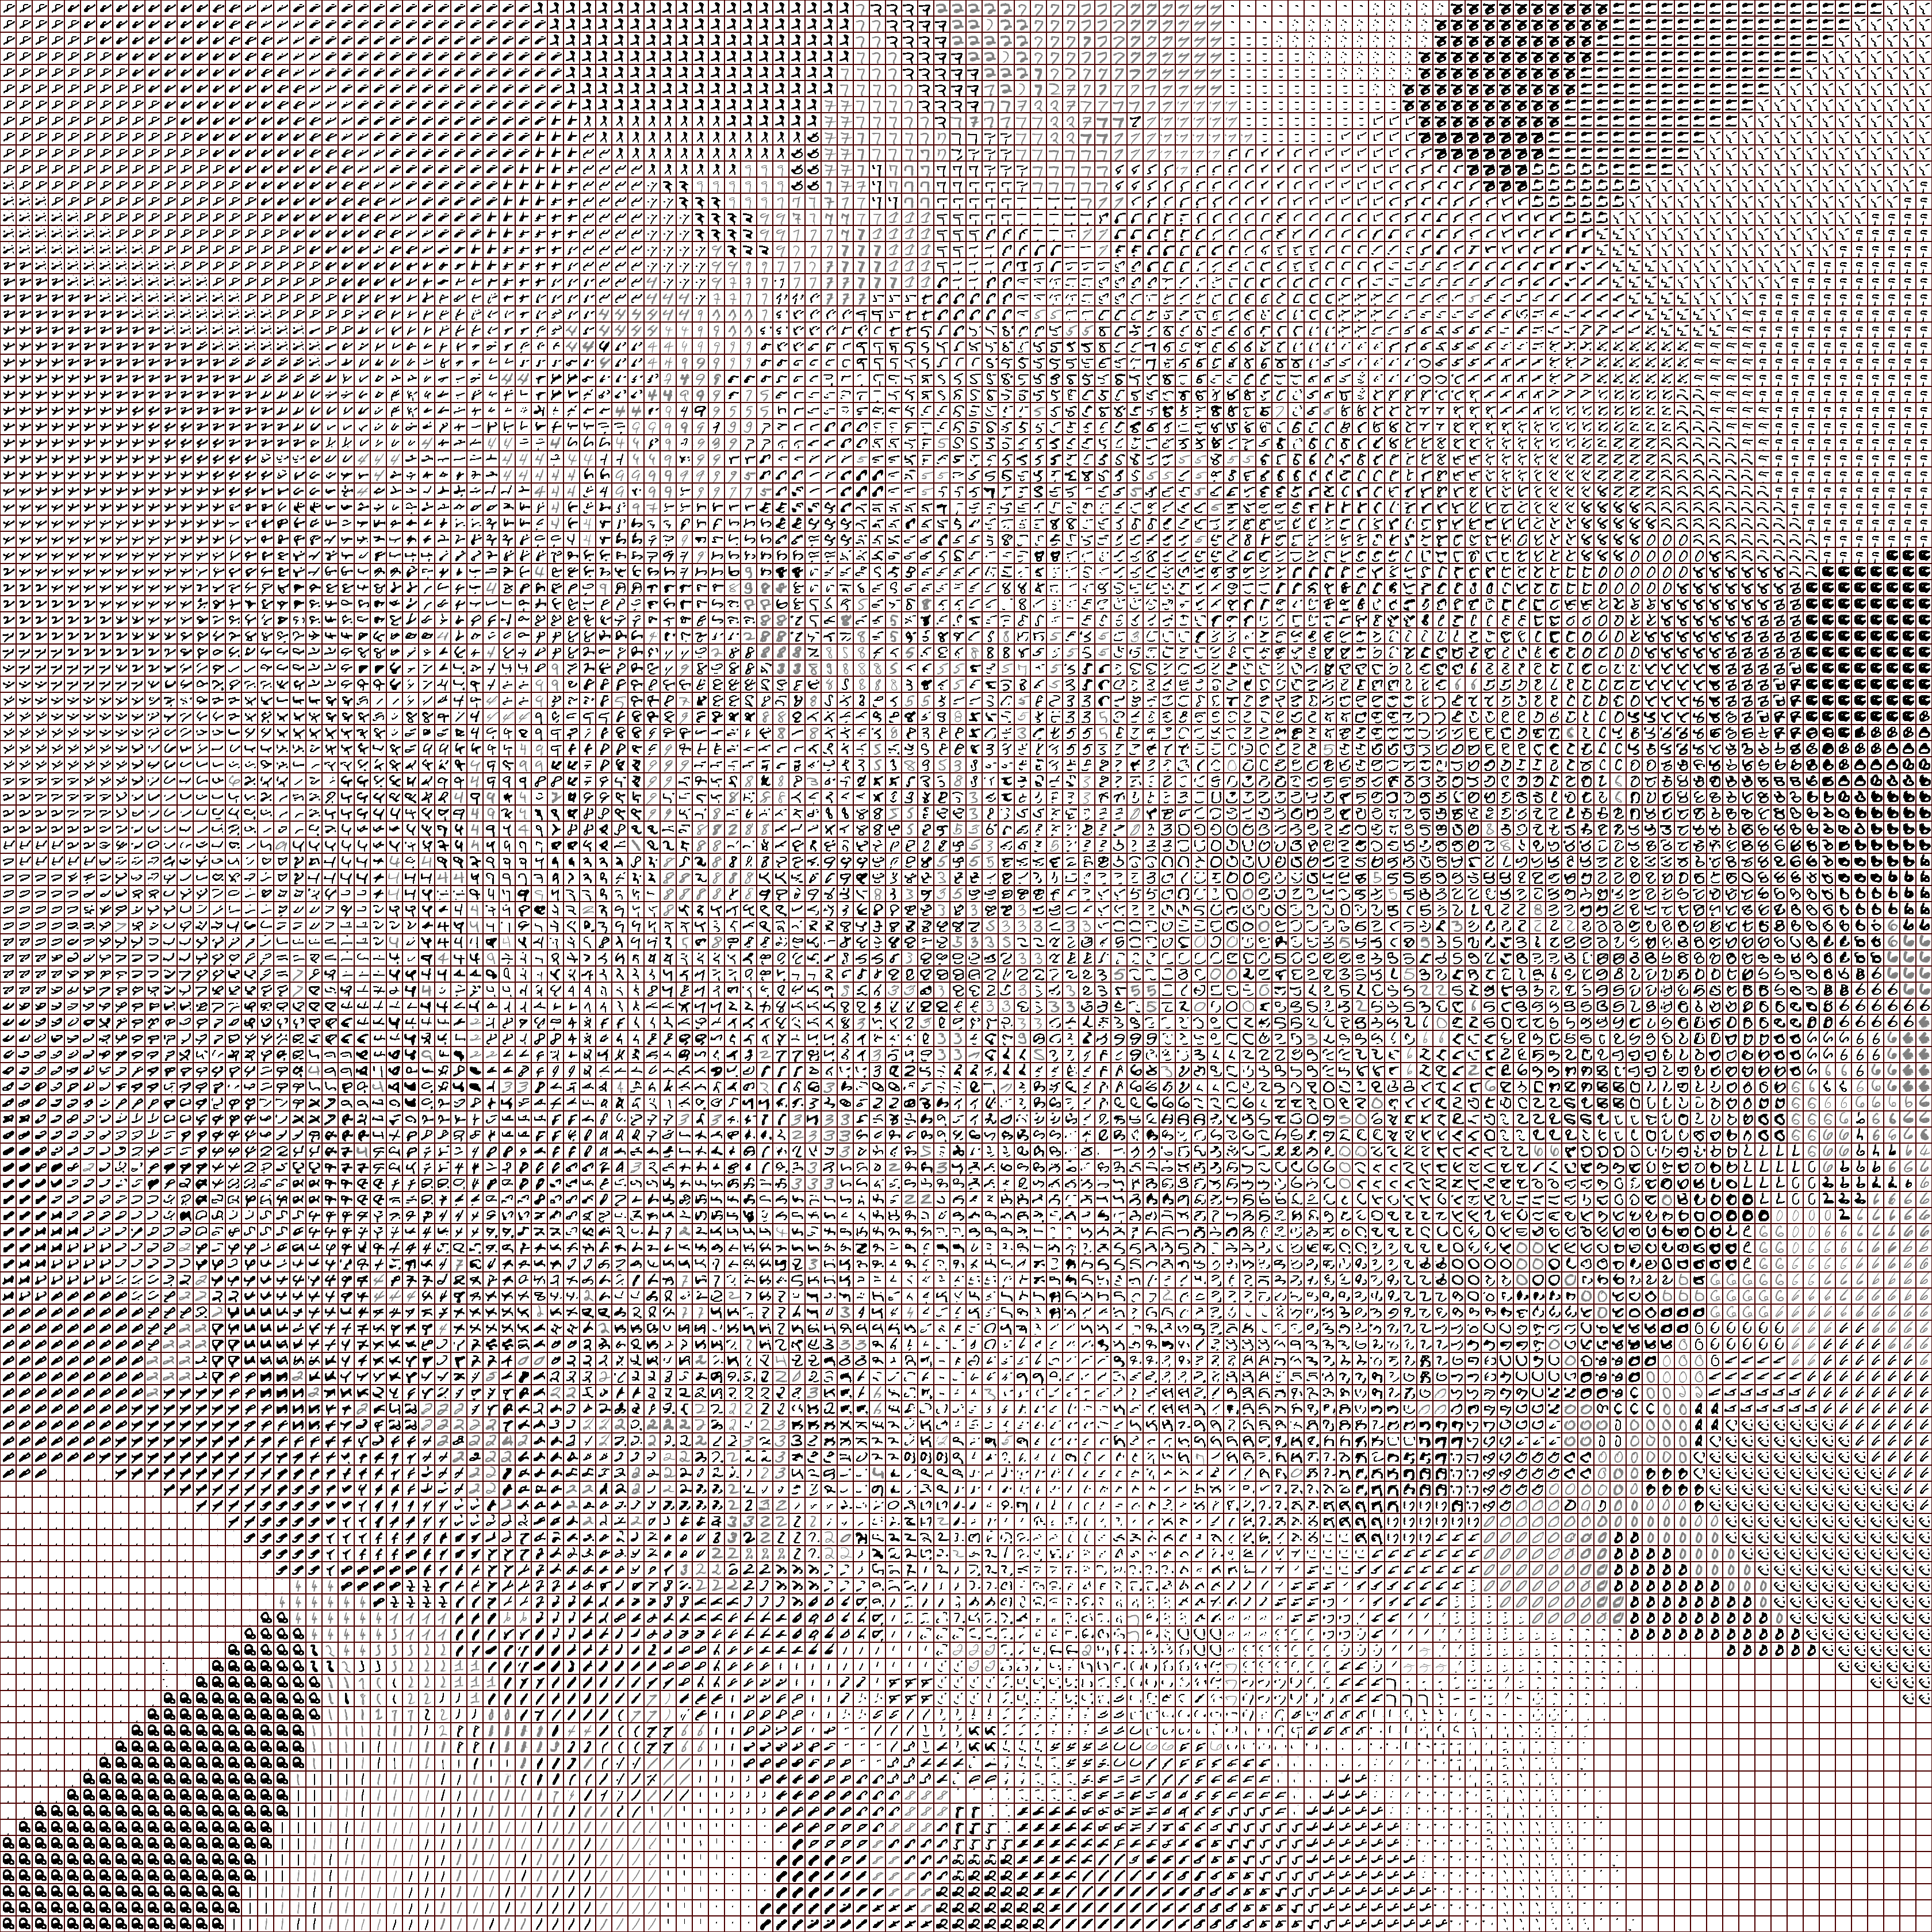

In [152]:
from sklearn.neighbors import NearestNeighbors
res = np.sqrt(len(h2d))
print(len(h2d))
x = np.linspace(0, 1, res)
y = np.linspace(0, 1, res)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
points = np.vstack((x, y)).T

knn = NearestNeighbors(n_neighbors=1)
h2d_ = (h2d - h2d.min(axis=0)) / (h2d.max(axis=0) - h2d.min(axis=0))
knn.fit(h2d_)
distances, indices = knn.kneighbors(points)
img = np.zeros((h*res, w*res, 3))
k = 0
for yy in np.arange(res):
    for xx in np.arange(res):
        s = d[indices[k]]
        im = s[0,0, :, :, np.newaxis]*np.ones((1, 1,3))
        if labels[indices[k]]==1:
            im[:,:]*=0.5
        im[:, 0, :]=[0.7,1,1]
        im[:, -1, :]=[0.7,1,1]
        im[0, :, :]=[0.7,1,1]
        im[-1, :, :]=[0.7,1,1]
        im = 1-im
        img[yy*h:yy*h+h, xx*w:xx*w+w, :] = im
        k += 1
imsave('imgs/out.png', img)
Image('imgs/out.png')

### GAN

In [ ]:
from skimage.transform import resize
import theano

In [ ]:
gen, discr = load_gan_model('../tools/mnist.pkl')

In [ ]:
X = T.tensor4()
discr_fn = theano.function([X], L.get_output(discr, X))

Z = T.matrix()
gen_fn = theano.function([Z], L.get_output(gen, Z))

In [ ]:
z_grad_fn = theano.function([X, Z], theano.grad( ((L.get_output(gen, Z)-X)**2).mean()  , Z))

In [ ]:
x_grad_n = theano.function([X], theano.grad(L.get_output(discr, X).mean(), X))

In [ ]:
def resize_set(x, w, h, **kw):
    x_out = np.empty((x.shape[0], 1, w, h))
    for i in range(len(x)):
        x_out[i, 0] = resize(x[i, 0], (w, h), **kw)
    return x_out.astype(np.float32)

In [ ]:
print(gen.output_shape)

In [ ]:
x = np.random.uniform(size=(9, 1, 28, 28)).astype(np.float32)
Z_of_X = np.random.uniform(-1, 1, size=(x.shape[0], 100)).astype(np.float32)


for i in range(20):
    #x += np.random.normal(0, 0.5, size=x.shape)
    x = capsule.reconstruct(x)
    x = x.astype(np.float32)
    x = resize_set(x, 32, 32)
    if True:
        z_rec = np.random.uniform(-1, 1, size=(x.shape[0], 100)).astype(np.float32)
        for _ in range(10):
            g = z_grad_fn(x, z_rec)
            z_rec -= 0.001*g
        
        gen = gen_fn(z_rec)
        gen =- gen.min(axis=0, keepdims=True)
        gen /= gen.max(axis=0, keepdims=True)
        x = x + (x - gen)
    if False:
        for _ in range(30):
            g = x_grad_n(x)
            x += 0.001*g
    x -= x.min(axis=(1, 2, 3), keepdims=True)
    x /= x.max(axis=(1, 2, 3), keepdims=True) 

    #x -= x.min(axis=0, keepdims=True)
    #x /= x.max(axis=0, keepdims=True) 

    x = resize_set(x, 28, 28, preserve_range=True)
    
    #x = x > 0.3
    x = x.astype(np.float32)

#x = resize_set(x, 32, 32)
print((discr_fn(x)).flatten().mean())

In [ ]:
img =  dispims_color(x.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
imsave('out.png', img)
Image('out.png')

## fine tuning

In [ ]:
from lasagnekit.datasets.mnist import MNIST
data_train = MNIST(which='train')
data_train.load()
data_test = MNIST(which='test')
data_test.load()

In [ ]:
def preprocess_feats(f):
    f = map(lambda f_i:f_i.reshape((f_i.shape[0], -1)), f)
    f = np.concatenate(f, axis=1)
    return f
train_feats = list(get_feats(capsule.preprocess(data_train.X)))
train_feats.append(data_train.X)
train_feats = preprocess_feats(train_feats)
test_feats = list(get_feats(capsule.preprocess(data_test.X)))
test_feats.append(data_test.X)
test_feats = preprocess_feats(test_feats)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
clf = make_pipeline(PCA(n_components=1000), LogisticRegression())
#clf = LogisticRegression()
clf.fit(train_feats, data_train.y)

In [ ]:
(clf.predict(train_feats)==data_train.y).mean()

In [ ]:
(clf.predict(test_feats) == data_test.y).mean()